In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Data Cleaning

### Formatting and Joining Dates

In [3]:
# Importing users datasets
cikmUsers1 = pd.read_csv('../data/test_set_users.txt', sep='\t', on_bad_lines='skip', names=['user_id', 'coordinates'], encoding='latin1')
cikmUsers2 = pd.read_csv('../data/training_set_users.txt', sep='\t', on_bad_lines='skip', names=['user_id', 'location'], encoding='latin1')

In [4]:
# Function to get coordinates
def getCoordinate(s:str, long:bool):
    if type(s) != str:
        return np.nan
    s = s.replace('UT:', '')
    return s.split(',')[long]

# Formatting coordinates column into long and lat
cikmUsers1['latitude'] = cikmUsers1['coordinates'].map(lambda x: getCoordinate(x, False))
cikmUsers1['longitude'] = cikmUsers1['coordinates'].map(lambda x: getCoordinate(x, True))

# Dropping coordinates column
cikmUsers1 = cikmUsers1.drop(['coordinates'], axis=1)

In [5]:
# Cleaning cikmUsers 2 location column
def getCityCoordinates(s:str, long:bool, citiesDF:pd.DataFrame):
    if type(s) != str:
        return np.nan
    
    location = s.split(',')
    city = location[0]
    if len(location) == 1:
        state = np.nan

        cities = citiesDF.loc[citiesDF['city'] == city.strip()].sort_values(by='population', ascending=False)
        if len(cities) == 0:
            return np.nan
        
        cityObs = cities.iloc[0]
        coordinates = [cityObs['lat'], cityObs['lng']]
    else:
        state = location[1]
        cities = citiesDF.loc[(citiesDF['city'] == city.strip()) & (citiesDF['state_id'] == state.strip())]
        if len(cities) == 0:
            return np.nan

        cityObs = cities.iloc[0]
        coordinates = [cityObs['lat'], cityObs['lng']]

    return coordinates[long]



    
# Getting long and lat for each observation
citiesDF = pd.read_csv('../data/uscities.csv')

cikmUsers2['latitude'] = cikmUsers2['location'].map(lambda x: getCityCoordinates(x, False, citiesDF))
cikmUsers2['longitude'] = cikmUsers2['location'].map(lambda x: getCityCoordinates(x, True, citiesDF))

# This cell takes like 7 min

KeyboardInterrupt: 

In [ ]:
# Drop non-needed columns
cikmUsers2 = cikmUsers2.drop(['location'], axis=1)

# Drop NAs in both 
cikmUsers1 = cikmUsers1.dropna()
cikmUsers2 = cikmUsers2.dropna()

# Concatenate into one big user dataset
cikmUsersDF = pd.concat([cikmUsers1, cikmUsers2],axis=0).reset_index(drop=True)
cikmUsersDF

,user_id,latitude,longitude
0,22077441,43.009815,-83.710408
1,17145858,38.856217,-90.056057
2,33931268,42.52548,-73.770351
3,19521541,40.735051,-74.228224
4,26976263,34.096153,-118.368732
...,...,...,...
102435,47185836,41.8375,-87.6866
102436,9437102,35.8324,-78.6429
102437,18000542,32.7935,-96.7667
102438,55574468,30.4413,-87.1911


## Joining Tweets Datasets

In [ ]:
# Importing datasets
cikmTweets1 = pd.read_csv('../data/test_set_tweets.txt', sep='\t', on_bad_lines='skip', names=['user_id', 'tweet_id', 'tweet', 'date'])
cikmTweets2 = pd.read_csv('../data/training_set_tweets.txt', sep='\t', on_bad_lines='skip', names=['user_id', 'tweet_id', 'tweet', 'date'])

# Dropping rows with NA values
cikmTweets1 = cikmTweets1.dropna()
cikmTweets2 = cikmTweets2.dropna()

/var/folders/sj/h8ss6gyd3v3ch7qgcmgk8sjm0000gn/T/ipykernel_71054/3819016077.py:3: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  cikmTweets2 = pd.read_csv('../data/training_set_tweets.txt', sep='\t', on_bad_lines='skip', names=['user_id', 'tweet_id', 'tweet', 'date'])


In [ ]:
# Removing columns we don't need
print("Removing columns...")
cikmTweets1 = cikmTweets1[['date','tweet', 'user_id']]
cikmTweets2 = cikmTweets2[['date','tweet', 'user_id']]

# Formatting the columns into the same dtypes
print("Formatting dates...")
cikmTweets1['date'] = pd.to_datetime(cikmTweets1['date'],errors='coerce',format='%Y-%m-%d %H:%M:%S')
cikmTweets2['date'] = pd.to_datetime(cikmTweets2['date'],errors='coerce',format='%Y-%m-%d %H:%M:%S')

# Normalizing dates to same timezone
print("Normalizing dates...")
cikmTweets1['date'] = cikmTweets1['date'].dt.tz_localize(None)
cikmTweets2['date'] = cikmTweets2['date'].dt.tz_localize(None)

# This cell takes around 1-2 minutes and throws and exception

Removing columns...
Formatting dates...
Normalizing dates...


In [ ]:
# Concatenating all of the dataframes into one
tweetsDF = pd.concat([cikmTweets1, cikmTweets2])

# Sorting by date
tweetsDF = tweetsDF.sort_values(by='date')

# Dropping NA values again (because some dates get coerced to NAs)
tweetsDF = tweetsDF.dropna()

In [ ]:
len(tweetsDF)

8755004

## Joining users and tweets

In [ ]:
# Making sure formatting is correct
cikmUsersDF = cikmUsersDF.apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1)
cikmUsersDF = cikmUsersDF.dropna()
tweetsDF['user_id'] = pd.to_numeric(tweetsDF['user_id'], errors='coerce')

# Doing an inner join on the tweets
completeTweetsDF = pd.merge(tweetsDF, cikmUsersDF, on='user_id')

# Number of tweets
len(completeTweetsDF)

8681441

## Date Range

<function matplotlib.pyplot.show(close=None, block=None)>

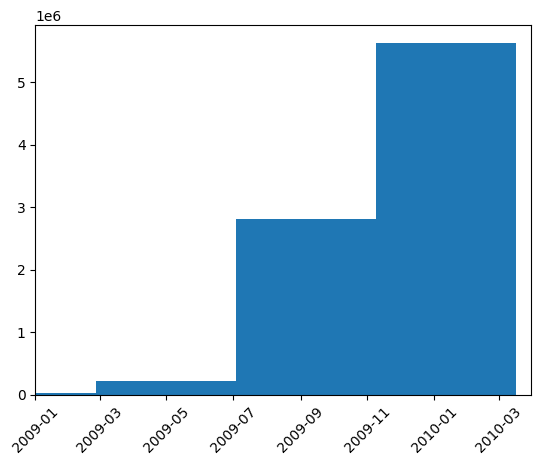

In [ ]:
plt.hist(completeTweetsDF.date)
plt.xlim(pd.Timestamp('2009-01-01'), pd.Timestamp('2010-07-31'))
plt.xticks(rotation=45)
plt.show

## Cleaning Tweets

In [ ]:
# Getting a sample of 20 tweets from the dataset
sample = completeTweetsDF.tweet.sample(n=20)

In [ ]:
sample

4960499    @Nupur1121 where did u move? Congrats on new job!
5430184    OOAK, Lavender & Purple Necklace, great gift i...
8381327    He's in it to win it #srsbns http://tweetphoto...
7227094    RSVP HERE --> (http://caltweet.com/4cr ) - Sin...
962526     RT @KinoSharp: @DJTECNEEK Happy bday my nigg &...
94002      @karltoss bueeeeeno despues de 1hr ya hasta ta...
7171689    RT @PrettyBrwn_n: #letsbehonest NY is the best...
6379497    Sitting in doctor's office and my 5 year old p...
5714715    I felt it was mii duty to boost her head even ...
1941119                        @souljaboytellem 469 261 5147
4647675    Photo: thongxxxy: Wow http://tumblr.com/xjn3sezi5
3324963        @Devon_Dazzle ditto. XOXO Gossip Girl xCHRISx
8661001      @JaeBarzthevamp yu been givin it away huh.. Smh
4043928    Feel the burn! Kristina-With-A-K has calorie-c...
4556483    I just unlocked the "Crunked" badge on @foursq...
4259020    RT @DetroitRedWings the first 5 out of state t...
943980     RT @jonesette

In [ ]:
# Function to clean tweets
def tweetCleaner(row):
    tweet = row['tweet']

    # Removing mentions
    tweet = re.sub(
        '(\A|\s)@(\w+)',
        '',
        tweet
    )

    # Removing links
    tweet = re.sub(
        'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+\S*|(?:https?://)?(?:www\.)?\w+\.\w{2,}(?:\.\w{2,})?',
        '',
        tweet
    )
    
    # Eliminate whitespace at the ends 
    tweet = tweet.strip()

    # Converting all words to lowercase
    tweet = tweet.lower()

    # Extracting and removing hashtags
    hashtags = ','.join(re.findall('[\s\W]#(\w+)', tweet))
    tweet = re.sub(
        '[\s\W]#(\w+)',
        '',
        tweet
    )

    # Removing special characters
    tweet = re.sub(
        '[^a-zA-Z ]',
        '',
        tweet
    )

    return pd.Series([tweet, hashtags, row['tweet']])



In [ ]:
completeTweetsDF[['tweet', 'hashtags', 'original_tweet']] = completeTweetsDF.apply(tweetCleaner, axis=1)
# Takes about 12 min

In [ ]:
completeTweetsDF

,date,tweet,user_id,latitude,longitude,hashtags,original_tweet
0,2006-09-10 11:07:07,trying to figure out what this thing is,5622.0,39.14130,-84.5060,,trying to figure out what this thing is.
1,2007-03-17 09:59:46,killing my land line,5622.0,39.14130,-84.5060,,killing my land line.
2,2007-03-18 11:48:24,my expense report,5622.0,39.14130,-84.5060,,my expense report
3,2007-03-21 12:20:05,putting down the llama book,5622.0,39.14130,-84.5060,,putting down the llama book.
4,2007-03-23 14:27:29,delegating,5622.0,39.14130,-84.5060,,delegating
...,...,...,...,...,...,...,...
8681436,2010-03-16 20:04:36,wassup,58669408.0,43.02179,-83.6757,,@Courtneyr35 wassup
8681437,2010-03-16 20:06:23,so tired,58669408.0,43.02179,-83.6757,,So tired!
8681438,2010-03-16 20:08:32,no im not,58669408.0,43.02179,-83.6757,,@Miyoko92 no I'm not!
8681439,2010-03-16 20:08:55,wat you up,58669408.0,43.02179,-83.6757,,@Courtneyr35 wat you up 2?


In [ ]:
completeTweetsDF.to_csv('../data/finalDF.csv')